# Create ML models for iminium reactions by non-H-bonding catalysts 

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import xgboost as xgb 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import LeaveOneOut

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

In [2]:
df = pd.read_excel('../data/dataset.xlsx',sheet_name='iminium')
full_X = df.iloc[:,11:]
full_y = df['DDG']

df_train, df_test = train_test_split(df, test_size=0.3, random_state=25)
X_train = df_train.iloc[:,11:]
y_train = df_train['DDG']
X_test = df_test.iloc[:, 11:]
y_test = df_test['DDG']

## XGboost

Best hyperparameters are: x__eta = 0.1,xgb__gamma = 0.0, xgb__max_depth = 3, xgb__min_child_weight = 8.102460577932023


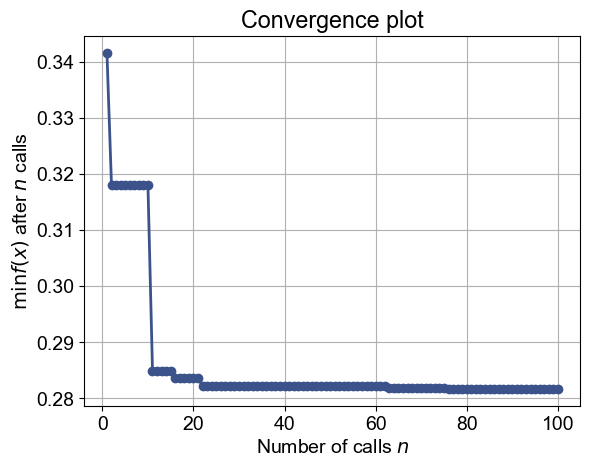

In [3]:
xgbpipe = Pipeline([('scaler', StandardScaler()), ('xgb', xgb.XGBRegressor())])

space  = [Real(0.1, 1, name='xgb__eta'),
          Real(0,2, name='xgb__gamma'),
          Integer(3, 10, name='xgb__max_depth'),
          Real(1, 20, name='xgb__min_child_weight')]

@use_named_args(space)
def objective(**params):
    xgbpipe.set_params(**params)

    return -np.mean(cross_val_score(xgbpipe, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

xgb_gp_min = gp_minimize(objective, space, n_calls=100, random_state=25, verbose=False)
plot_convergence(xgb_gp_min)
print('=====================')
print(f'Best hyperparameters are: x__eta = {xgb_gp_min.x[0]},xgb__gamma = {xgb_gp_min.x[1]}, xgb__max_depth = {xgb_gp_min.x[2]}, xgb__min_child_weight = {xgb_gp_min.x[3]}')

In [4]:
xgbtrain_pred = xgbpipe.set_params(xgb__eta = xgb_gp_min.x[0],xgb__gamma = xgb_gp_min.x[1], xgb__max_depth = xgb_gp_min.x[2], xgb__min_child_weight = xgb_gp_min.x[3]).fit(X_train, y_train).predict(X_train)
xgbtest_pred = xgbpipe.set_params(xgb__eta = xgb_gp_min.x[0],xgb__gamma = xgb_gp_min.x[1], xgb__max_depth = xgb_gp_min.x[2], xgb__min_child_weight = xgb_gp_min.x[3]).fit(X_train, y_train).predict(X_test)


# RF

Best hyperparameters are: rf__n_estimators = 154,rf__max_depth = 96, rf__min_samples_split = 6


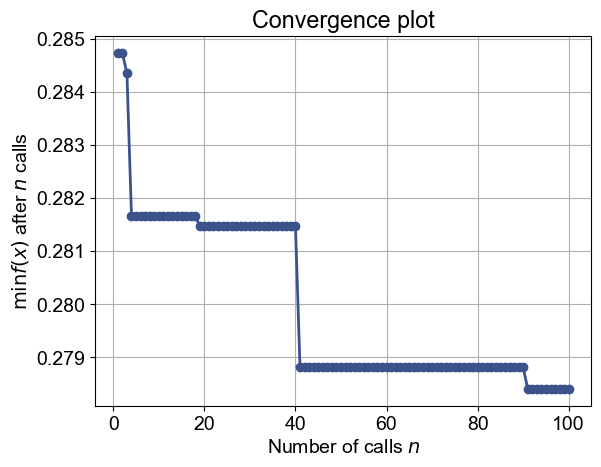

In [5]:
rfpipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

space  = [Integer(10,200, name='rf__n_estimators'),
          Integer(2,100, name='rf__max_depth'),
          Integer(2,20, name='rf__min_samples_split')]

@use_named_args(space)
def objective(**params):
    rfpipe.set_params(**params)

    return -np.mean(cross_val_score(rfpipe, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

rf_gp_min = gp_minimize(objective, space, n_calls=100, random_state=25, verbose=False)
plot_convergence(rf_gp_min)
print('=====================')
print(f'Best hyperparameters are: rf__n_estimators = {rf_gp_min.x[0]},rf__max_depth = {rf_gp_min.x[1]}, rf__min_samples_split = {rf_gp_min.x[2]}')


In [6]:
rftrain_pred = rfpipe.set_params(rf__n_estimators = rf_gp_min.x[0],rf__max_depth = rf_gp_min.x[1], rf__min_samples_split = rf_gp_min.x[2]).fit(X_train, y_train).predict(X_train)
rftest_pred = rfpipe.set_params(rf__n_estimators = rf_gp_min.x[0],rf__max_depth = rf_gp_min.x[1], rf__min_samples_split = rf_gp_min.x[2]).fit(X_train, y_train).predict(X_test)


# SVR

Best hyperparameters are: svr__kernel = rbf,svr__tol = 0.03597222589319736


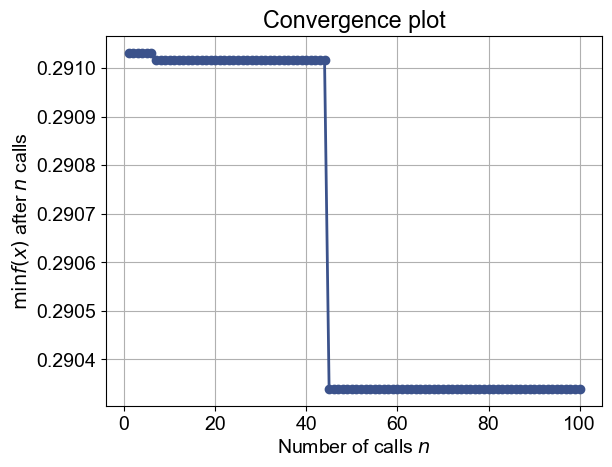

In [7]:
svrpipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])

space  = [Categorical(['linear','poly','rbf','sigmoid'], name='svr__kernel'),
          Real(0.0001, 0.1, "log-uniform", name='svr__tol')]

@use_named_args(space)
def objective(**params):
    svrpipe.set_params(**params)

    return -np.mean(cross_val_score(svrpipe, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

svr_gp_min = gp_minimize(objective, space, n_calls=100, random_state=25, verbose=False)
plot_convergence(svr_gp_min)
print('=====================')
print(f'Best hyperparameters are: svr__kernel = {svr_gp_min.x[0]},svr__tol = {svr_gp_min.x[1]}')


In [8]:
svrtrain_pred = svrpipe.set_params(svr__kernel = svr_gp_min.x[0],svr__tol = svr_gp_min.x[1]).fit(X_train, y_train).predict(X_train)
svrtest_pred = svrpipe.set_params(svr__kernel = svr_gp_min.x[0],svr__tol = svr_gp_min.x[1]).fit(X_train, y_train).predict(X_test)


# KNN

Best hyperparameters are: knn__weights = distance,knn__algorithm = ball_tree, knn__leaf_size = 1, knn__n_neighbors = 16, knn__p = 1


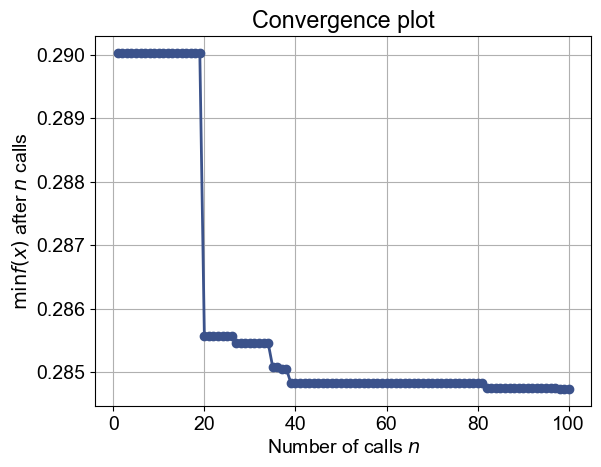

In [9]:
knnpipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

space  = [Categorical(['uniform','distance'], name='knn__weights'),
          Categorical(['auto', 'ball_tree', 'kd_tree', 'brute'], name='knn__algorithm'),
          Integer(1,60, name='knn__leaf_size'),
          Integer(1,50, name='knn__n_neighbors'),
          Integer(1,2, name='knn__p')]

@use_named_args(space)
def objective(**params):
    knnpipe.set_params(**params)

    return -np.mean(cross_val_score(knnpipe, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

knn_gp_min = gp_minimize(objective, space, n_calls=100, random_state=25, verbose=False)
plot_convergence(knn_gp_min)
print('=====================')
print(f'Best hyperparameters are: knn__weights = {knn_gp_min.x[0]},knn__algorithm = {knn_gp_min.x[1]}, knn__leaf_size = {knn_gp_min.x[2]}, knn__n_neighbors = {knn_gp_min.x[3]}, knn__p = {knn_gp_min.x[4]}')

In [10]:
knntrain_pred = knnpipe.set_params(knn__weights=knn_gp_min.x[0], knn__algorithm=knn_gp_min.x[1],knn__leaf_size = knn_gp_min.x[2], knn__n_neighbors = knn_gp_min.x[3], knn__p = knn_gp_min.x[4]).fit(X_train, y_train).predict(X_train)
knntest_pred = knnpipe.set_params(knn__weights=knn_gp_min.x[0], knn__algorithm=knn_gp_min.x[1],knn__leaf_size = knn_gp_min.x[2], knn__n_neighbors = knn_gp_min.x[3], knn__p = knn_gp_min.x[4]).fit(X_train, y_train).predict(X_test)


## Calculate LOO for full dataset

In [11]:

loo_ys = []
loo_xgb = []
loo_rf = []
loo_svr = []
loo_knn = []

for i, (train_index, test_index) in enumerate(LeaveOneOut().split(full_X)):
    loo_X_train, loo_X_test = full_X.iloc[train_index], full_X.iloc[test_index]
    loo_y_train, loo_y_test = full_y.iloc[train_index], full_y.iloc[test_index]

    loo_ys.extend(loo_y_test)

    loo_xgb.extend(xgbpipe.set_params(xgb__eta = xgb_gp_min.x[0],xgb__gamma = xgb_gp_min.x[1], 
                       xgb__max_depth = xgb_gp_min.x[2], xgb__min_child_weight = xgb_gp_min.x[3]).fit(loo_X_train, loo_y_train).predict(loo_X_test))
    
    loo_rf.extend(rfpipe.set_params(rf__n_estimators = rf_gp_min.x[0],
                      rf__max_depth = rf_gp_min.x[1], rf__min_samples_split = rf_gp_min.x[2]).fit(loo_X_train, loo_y_train).predict(loo_X_test))
    
    loo_svr.extend(svrpipe.set_params(svr__kernel = svr_gp_min.x[0],svr__tol = svr_gp_min.x[1]).fit(loo_X_train, loo_y_train).predict(loo_X_test))

    loo_knn.extend(knnpipe.set_params(knn__weights=knn_gp_min.x[0], knn__algorithm=knn_gp_min.x[1],
                       knn__leaf_size = knn_gp_min.x[2], knn__n_neighbors = knn_gp_min.x[3], knn__p = knn_gp_min.x[4]).fit(loo_X_train, loo_y_train).predict(loo_X_test))



# Full visualization

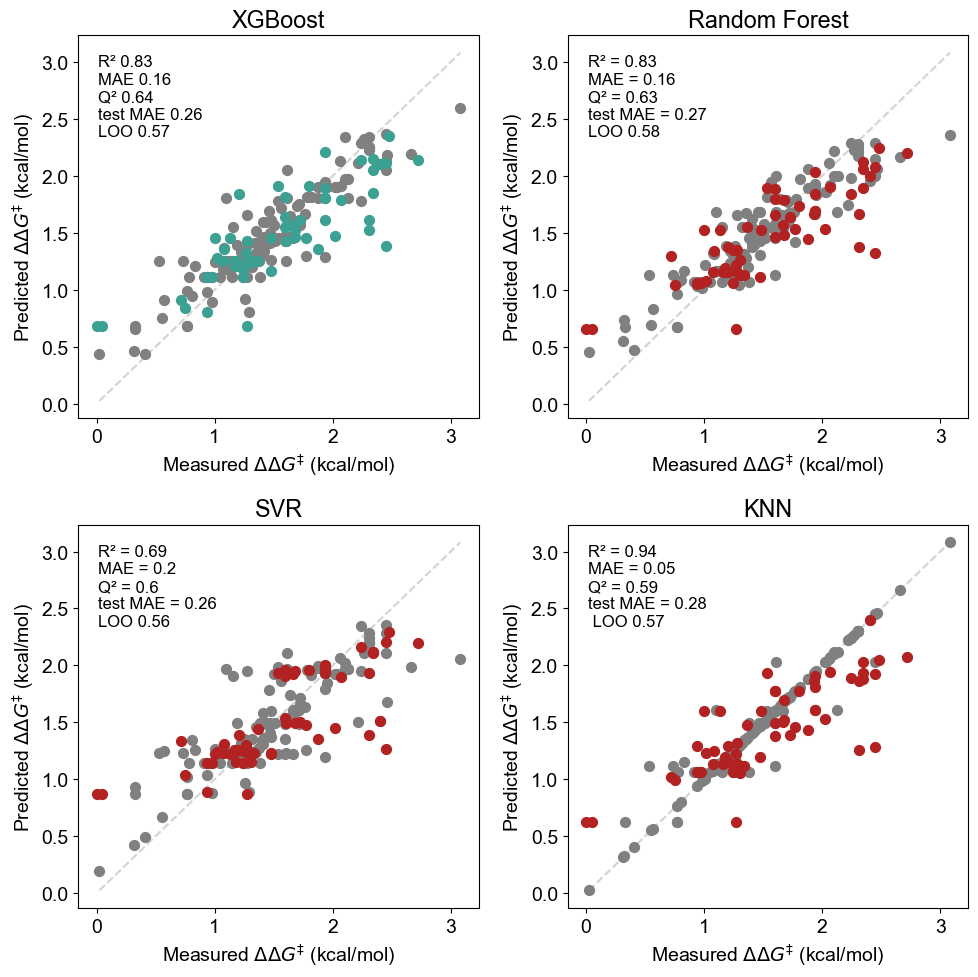

In [13]:

fig, ax = plt.subplots(2, 2, figsize=(10, 10))


ax[0, 0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], ls="--", zorder=0, color='lightgrey')
ax[0, 0].scatter(y_train, xgbtrain_pred, label='Train', color='grey',  s=50)
ax[0, 0].scatter(y_test, xgbtest_pred, label='Test', color='#3ca093',  s=50)
ax[0, 0].set_xlabel(r'Measured $\Delta \Delta G^‡$ (kcal/mol)')
ax[0, 0].set_ylabel(r'Predicted $\Delta \Delta G^‡$ (kcal/mol)')
ax[0, 0].set_title('XGBoost')
ax[0, 0].text(0.05, 0.95, 
              f'R² {round(r2_score(y_train,xgbtrain_pred),2)}\nMAE {round(mean_absolute_error(y_train,xgbtrain_pred),2)}\nQ² {round(r2_score(y_test,xgbtest_pred),2)}\ntest MAE {round(mean_absolute_error(y_test,xgbtest_pred),2)}\nLOO {round(r2_score(loo_ys,loo_xgb),2)}', 
              transform=ax[0, 0].transAxes, fontsize=12, verticalalignment='top')


ax[0, 1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], ls="--", zorder=0, color='lightgrey')
ax[0, 1].scatter(y_train, rftrain_pred, label='Train', color='grey',  s=50)
ax[0, 1].scatter(y_test, rftest_pred, label='Test', color='firebrick',  s=50)
ax[0, 1].set_xlabel(r'Measured $\Delta \Delta G^‡$ (kcal/mol)')
ax[0, 1].set_ylabel(r'Predicted $\Delta \Delta G^‡$ (kcal/mol)')
ax[0, 1].set_title('Random Forest')
ax[0,1].text(0.05, 0.95,
                f'R² = {round(r2_score(y_train,rftrain_pred),2)}\nMAE = {round(mean_absolute_error(y_train,rftrain_pred),2)}\nQ² = {round(r2_score(y_test,rftest_pred),2)}\ntest MAE = {round(mean_absolute_error(y_test,rftest_pred),2)}\nLOO {round(r2_score(loo_ys,loo_rf),2)}',
                transform=ax[0, 1].transAxes, fontsize=12, verticalalignment='top')

ax[1, 0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], ls="--", zorder=0, color='lightgrey')
ax[1, 0].scatter(y_train, svrtrain_pred, label='Train', color='grey',  s=50)
ax[1, 0].scatter(y_test, svrtest_pred, label='Test', color='firebrick',  s=50)
ax[1, 0].set_xlabel(r'Measured $\Delta \Delta G^‡$ (kcal/mol)')
ax[1, 0].set_ylabel(r'Predicted $\Delta \Delta G^‡$ (kcal/mol)')
ax[1, 0].set_title('SVR')
ax[1, 0].text(0.05, 0.95,
                f'R² = {round(r2_score(y_train,svrtrain_pred),2)}\nMAE = {round(mean_absolute_error(y_train,svrtrain_pred),2)}\nQ² = {round(r2_score(y_test,svrtest_pred),2)}\ntest MAE = {round(mean_absolute_error(y_test,svrtest_pred),2)}\nLOO {round(r2_score(loo_ys,loo_svr),2)}',
                transform=ax[1, 0].transAxes, fontsize=12, verticalalignment='top')

ax[1, 1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], ls="--", zorder=0, color='lightgrey')
ax[1, 1].scatter(y_train, knntrain_pred, label='Train', color='grey',  s=50)
ax[1, 1].scatter(y_test, knntest_pred, label='Test', color='firebrick',  s=50)
ax[1, 1].set_xlabel(r'Measured $\Delta \Delta G^‡$ (kcal/mol)')
ax[1, 1].set_ylabel(r'Predicted $\Delta \Delta G^‡$ (kcal/mol)')
ax[1, 1].set_title('KNN')
ax[1, 1].text(0.05, 0.95,
                f'R² = {round(r2_score(y_train,knntrain_pred),2)}\nMAE = {round(mean_absolute_error(y_train,knntrain_pred),2)}\nQ² = {round(r2_score(y_test,knntest_pred),2)}\ntest MAE = {round(mean_absolute_error(y_test,knntest_pred),2)}\n LOO {round(r2_score(loo_ys,loo_knn),2)}',
                transform=ax[1, 1].transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('../../../models.png', dpi=300, bbox_inches='tight')
plt.show()